In [1]:
import numpy as np
import matplotlib.pyplot as plt
import jax.numpy as jnp
from jax import vmap

from distributions import Cauchy, Gaussian, Gamma, Laplace, T
from kernels import (
    PolynomialKernel,
    GaussianKernel,
    LaplacianKernel,
    InverseMultiQuadraticKernel,
    SteinKernel,
)
from discrepancies import MaximumMeanDiscrepancy, KernelSteinDiscrepancy

In [2]:
np.random.seed(0)
plt.rc("legend", fontsize=7)

In this section, we will explore the Kernel Stein Discrepancy (KSD). Unlike the MMD which compares samples from two distributions $\mathbb{P}$ and $\mathbb{Q}$, the KSD compares a known distribution $\mathbb{P}$ to samples from $\mathbb{Q}$. In cases where we know $\mathbb{P}$ or we would like to compare $\mathbb{Q}$ to a known distribution $\mathbb{P}$, the KSD may be more suitable as it utilises the full $\mathbb{P}$ distribution within its formulation, rather than a finite number of $\mathbb{P}$ samples in the MMD case.

# $\mathbb{P}$ Distributions

To begin, we need to define a known distribution. We assume the distribution is of the form:

$$p(x; \theta) = \frac{1}{z(\theta)}\tilde{p}(x)$$

where $\theta$ are the parameters of the distribution

## Gaussian

As an example, we will use the multi-variate Gaussian:

$$p(x) = p(x; \mu, \Sigma) = \frac{1}{(2\pi)^{n/2}|\Sigma|^{1/2}} \exp(-\frac{1}{2}(x-\mu)^T \Sigma^{-1}(x-\mu))$$

where:

$$\tilde{p}(x) = \exp(-\frac{1}{2}(x-\mu)^T \Sigma^{-1}(x-\mu))$$

and 

$$z(\theta) = (2\pi)^{n/2}|\Sigma|^{1/2}$$

We can derive:

$$\log {p}(x) = -\frac{1}{2}(x-\mu)^T \Sigma^{-1}(x-\mu) - \log (z(\theta))$$

and

$$\nabla_x \log {p}(x) = - \Sigma^{-1} (x-\mu)$$

The quantity $\nabla_x \log {p}(x)$ is also known as the score of $p(x)$.

For visualisation, we can plot the various quantities of interest for a given Gaussian.

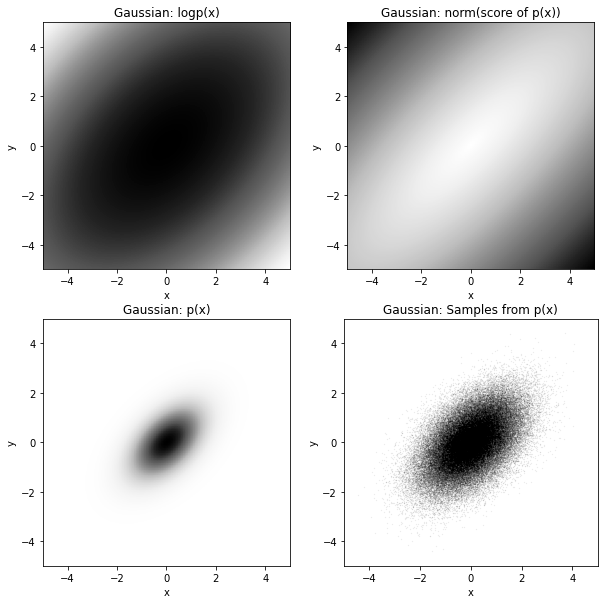

In [3]:
gaussian = Gaussian(
    mu=np.zeros((2,)),
    covariance=np.array(
        [
            [1, 0.5],
            [0.5, 1],
        ]
    ),
)

N = 101
M = 101
x_min, x_max = -5, 5
y_min, y_max = -5, 5
x_ticks = np.linspace(x_min, x_max, N)
y_ticks = np.linspace(y_min, y_max, M)
xx, yy = np.meshgrid(x_ticks, y_ticks)
x = np.stack((xx, yy)).reshape(2, N * M).T

fig, ax = plt.subplots(2, 2)
fig.set_figwidth(10)
fig.set_figheight(10)

ax[0][0].imshow(
    np.flip(vmap(gaussian.log_p)(x).reshape(xx.shape), axis=1),
    cmap="Greys",
    extent=[x_min, x_max, y_min, y_max],
)
ax[0][0].set_xlabel("x")
ax[0][0].set_ylabel("y")
ax[0][0].set_title("Gaussian: logp(x)")

ax[0][1].imshow(
    np.flip(np.linalg.norm(vmap(gaussian.score)(x), axis=1).reshape(xx.shape), axis=1),
    cmap="Greys",
    extent=[x_min, x_max, y_min, y_max],
)
ax[0][1].set_xlabel("x")
ax[0][1].set_ylabel("y")
ax[0][1].set_title("Gaussian: norm(score of p(x))")

ax[1][0].imshow(
    np.flip(vmap(gaussian.p)(x).reshape(xx.shape), axis=1),
    cmap="Greys",
    extent=[x_min, x_max, y_min, y_max],
)
ax[1][0].set_xlabel("x")
ax[1][0].set_ylabel("y")
ax[1][0].set_title("Gaussian: p(x)")

samples = gaussian.sample(int(1e5))
ax[1][1].scatter(samples[:, 0], samples[:, 1], c="black", s=0.1, alpha=1e-1)
ax[1][1].set_xlabel("x")
ax[1][1].set_ylabel("y")
ax[1][1].set_title("Gaussian: Samples from p(x)")
plt.xlim([x_min, x_max])
plt.ylim([y_min, y_max])
plt.show()

## Derivatives

In [4]:
def calculate_numerical_derivative(
    f_x_h: np.ndarray, f_x: np.ndarray, h: float
) -> np.ndarray:
    return (f_x_h - f_x) / h

We can verify the derivative of the log-likelihood:

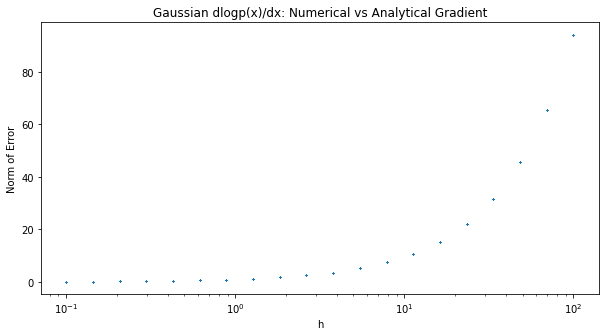

In [5]:
N = 50
M = 50
x = np.linspace(-2, 2, N)
y = np.linspace(-2, 2, M)
xx, yy = np.meshgrid(x, y)
x = np.stack((xx, yy)).reshape(2, N * M).T
hs = np.logspace(-1, 2, 20)
h_used = np.repeat(hs, N * M).reshape(-1, N * M)

actual_gradient = vmap(lambda x_i: gaussian.score(x_i))(x)
numerical_gradients = vmap(
    lambda h: vmap(
        lambda x_i: vmap(
            lambda x_i_h: calculate_numerical_derivative(
                f_x_h=gaussian.log_p_tilda(x_i_h), f_x=gaussian.log_p_tilda(x_i), h=h
            )
        )(x_i + h * np.eye(2))
    )(x)
)(hs)
error_norm = vmap(
    lambda numerical_gradient: jnp.linalg.norm(
        actual_gradient - numerical_gradient, axis=1
    )
)(numerical_gradients)

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
fig.set_figwidth(10)
fig.set_figheight(5)
ax.set_title("Gaussian dlogp(x)/dx: Numerical vs Analytical Gradient")
ax.set_xscale("log")
ax.set_xlabel("h")
ax.set_ylabel("Norm of Error")
plt.scatter(h_used.flatten(), error_norm.flatten(), s=0.1)
plt.show()

# Stein Kernels

We are now ready to define the Stein Kernel. This is a special formulation of a kernel. For a given distribution $\mathbb{P}$ and kernel $k(x,y)$, the Stein kernel $k_{\mathbb{P}}(x, y)$ is defined as,

$$k_{\mathbb{P}}(x, y) = \nabla_x \log {p}(x)^T \nabla_x \log {p}(y)^T k(x, y) 
+ \nabla_x \log {p}(y)^T \nabla_x k(x, y)
+ \nabla_x \log {p}(x)^T \nabla_y k(x, y)
+ \langle \nabla_x k(x, \cdot), \nabla_y k(\cdot, y) \rangle$$

where,

$$\langle \nabla_x k(x, \cdot), \nabla_y k(\cdot, y) \rangle = \sum_{i=1}^d \frac{\partial k(x,y)}{\partial x_i \partial y_i} = Tr(\nabla_x \nabla_y k(x, y))$$

We can visualise the kernel with respect to its different parameters:

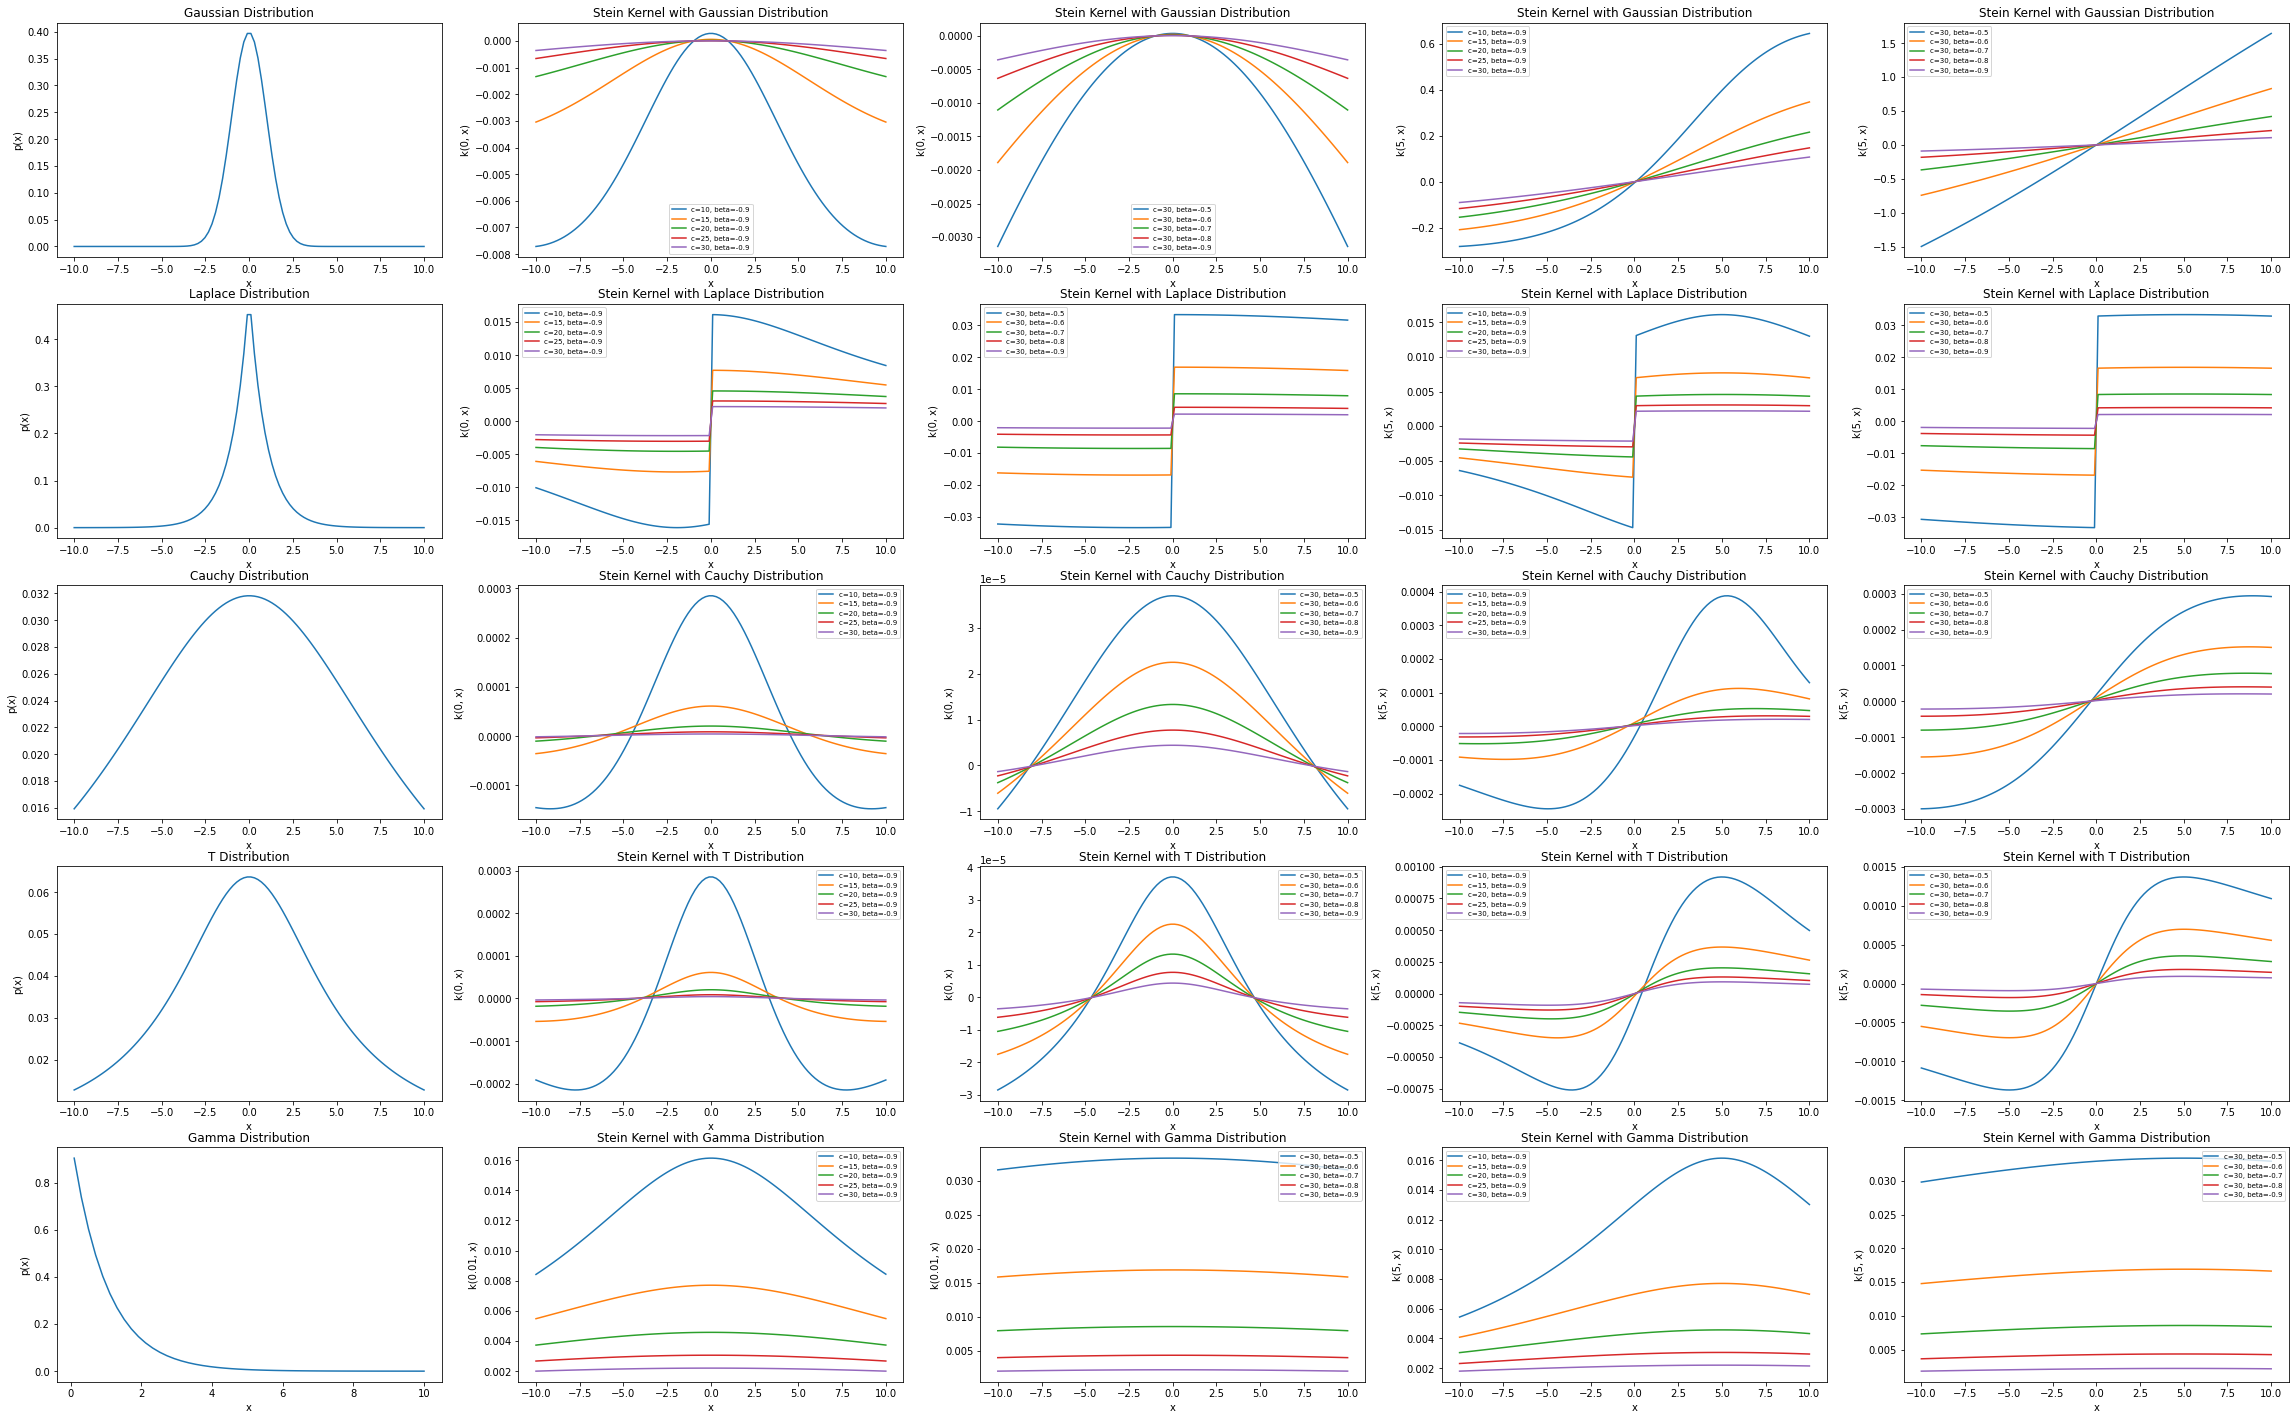

In [6]:
scaling_factors = np.linspace(-10, 10, 100).astype(float)
dimensions = 1
distributions = [
    Gaussian(mu=np.zeros((1, 1)), covariance=np.eye(1)),
    Laplace(0, 1),
    Cauchy(x0=0, gamma=10),
    T(degrees_of_freedom=1, loc=0, scale=5),
    Gamma(k=1, theta=1),
]


fig, axs = plt.subplots(len(distributions), 5)
fig.set_figheight(len(distributions) * 5)
fig.set_figwidth(40)

j = 0
for i, distribution in enumerate(distributions):
    axs[i][j].plot(
        scaling_factors, vmap(lambda x_i: distribution.p(x_i))(scaling_factors)
    )
    axs[i][j].set_title(f"{type(distribution).__name__} Distribution")
    axs[i][j].set_xlabel("x")
    axs[i][j].set_ylabel("p(x)")

j = 1
beta = -0.9
x_is = [0, 0, 0, 0, 1e-2]
for c in [10, 15, 20, 25, 30]:
    for i, distribution in enumerate(distributions):
        inverse_multi_quadratic_kernel = InverseMultiQuadraticKernel(c, beta)
        stein_kernel = SteinKernel(
            distribution=distribution, kernel=inverse_multi_quadratic_kernel
        )
        k_values = vmap(
            lambda y: stein_kernel.k(
                x=x_is[i] * np.ones((dimensions,)),
                y=y,
            )
        )(scaling_factors.reshape(-1, 1)).reshape(-1)
        axs[i][j].plot(scaling_factors, k_values, label=f"{c=}, {beta=}")
        axs[i][j].legend()
        axs[i][j].set_title(
            f"Stein Kernel with {type(distribution).__name__} Distribution"
        )
        axs[i][j].set_xlabel("x")
        axs[i][j].set_ylabel(f"k({x_is[i]}, x)")

j = 2
c = 30
for beta in [-0.5, -0.6, -0.7, -0.8, -0.9]:
    for i, distribution in enumerate(distributions):
        inverse_multi_quadratic_kernel = InverseMultiQuadraticKernel(c, beta)
        stein_kernel = SteinKernel(
            distribution=distribution, kernel=inverse_multi_quadratic_kernel
        )
        k_values = vmap(
            lambda y: stein_kernel.k(
                x=x_is[i] * np.ones((dimensions,)),
                y=y,
            )
        )(scaling_factors.reshape(-1, 1)).reshape(-1)
        axs[i][j].plot(scaling_factors, k_values, label=f"{c=}, {beta=}")
        axs[i][j].legend()
        axs[i][j].set_title(
            f"Stein Kernel with {type(distribution).__name__} Distribution"
        )
        axs[i][j].set_xlabel("x")
        axs[i][j].set_ylabel(f"k({x_is[i]}, x)")


j = 3
beta = -0.9
x_is = [5, 5, 5, 5, 5]
for c in [10, 15, 20, 25, 30]:
    for i, distribution in enumerate(distributions):
        inverse_multi_quadratic_kernel = InverseMultiQuadraticKernel(c, beta)
        stein_kernel = SteinKernel(
            distribution=distribution, kernel=inverse_multi_quadratic_kernel
        )
        k_values = vmap(
            lambda y: stein_kernel.k(
                x=x_is[i] * np.ones((dimensions,)),
                y=y,
            )
        )(scaling_factors.reshape(-1, 1)).reshape(-1)
        axs[i][j].plot(scaling_factors, k_values, label=f"{c=}, {beta=}")
        axs[i][j].legend()
        axs[i][j].set_title(
            f"Stein Kernel with {type(distribution).__name__} Distribution"
        )
        axs[i][j].set_xlabel("x")
        axs[i][j].set_ylabel(f"k({x_is[i]}, x)")

j = 4
c = 30
for beta in [-0.5, -0.6, -0.7, -0.8, -0.9]:
    for i, distribution in enumerate(distributions):
        inverse_multi_quadratic_kernel = InverseMultiQuadraticKernel(c, beta)
        stein_kernel = SteinKernel(
            distribution=distribution, kernel=inverse_multi_quadratic_kernel
        )
        k_values = vmap(
            lambda y: stein_kernel.k(
                x=x_is[i] * np.ones((dimensions,)),
                y=y,
            )
        )(scaling_factors.reshape(-1, 1)).reshape(-1)
        axs[i][j].plot(scaling_factors, k_values, label=f"{c=}, {beta=}")
        axs[i][j].legend()
        axs[i][j].set_title(
            f"Stein Kernel with {type(distribution).__name__} Distribution"
        )
        axs[i][j].set_xlabel("x")
        axs[i][j].set_ylabel(f"k({x_is[i]}, x)")

We can also visually compare the Stein Kernels across different seed kernels.

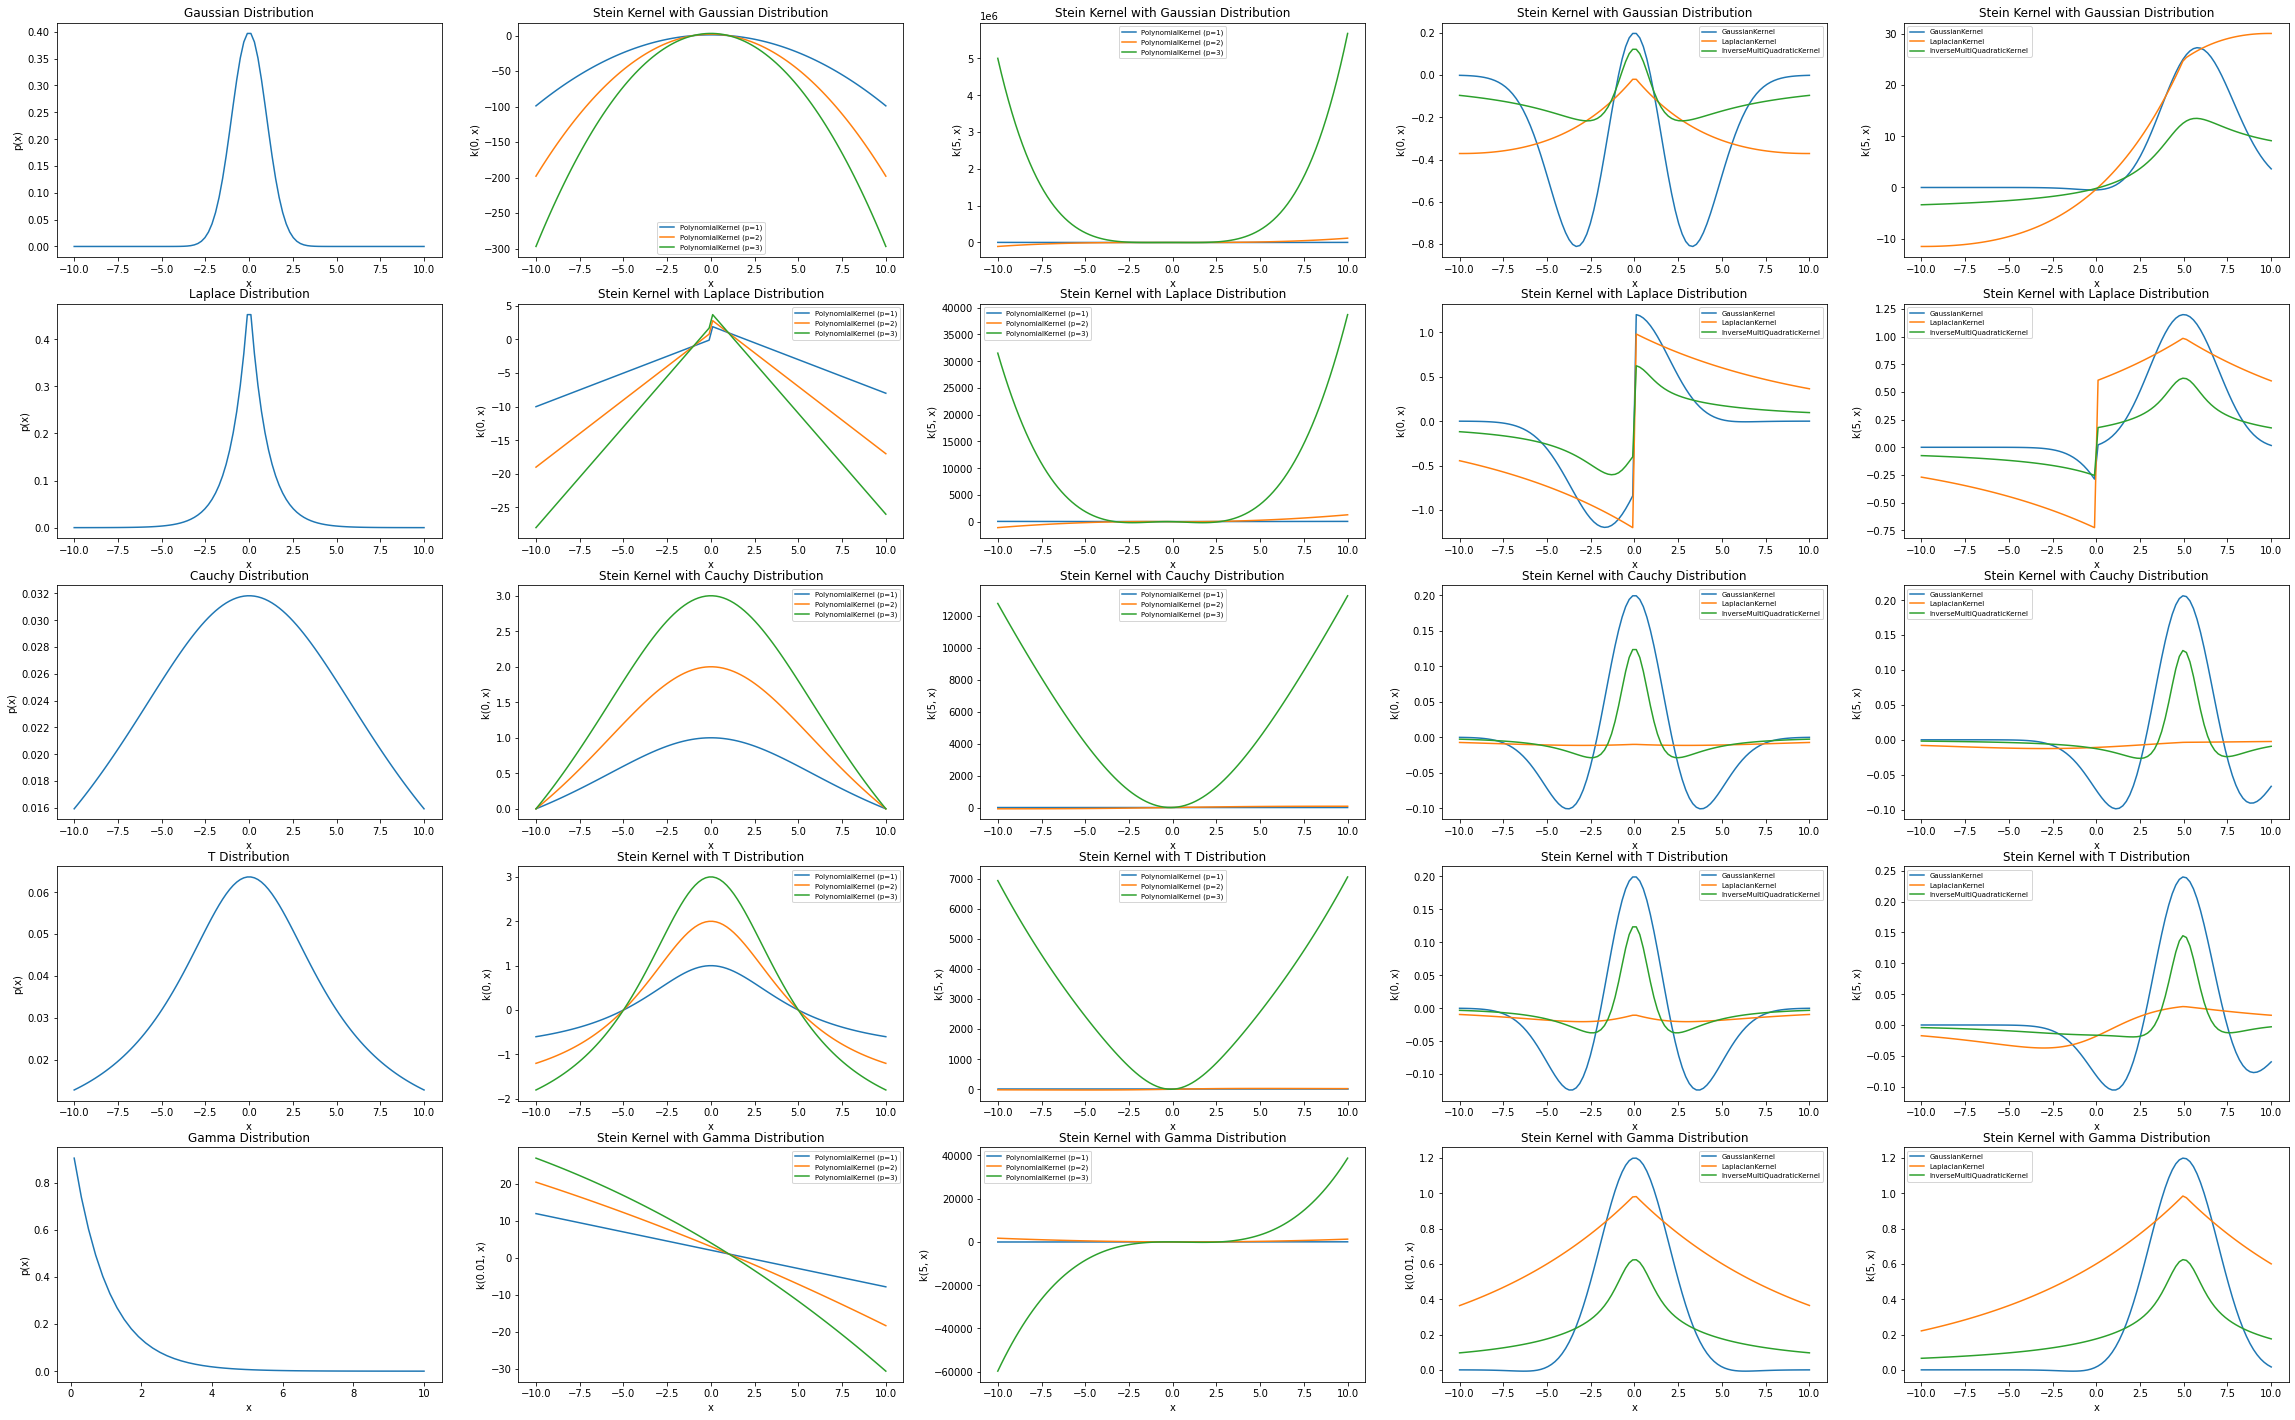

In [7]:
scaling_factors = np.linspace(-10, 10, 100).astype(float)
dimensions = 1
distributions = [
    Gaussian(mu=np.zeros((1, 1)), covariance=np.eye(1)),
    Laplace(0, 1),
    Cauchy(x0=0, gamma=10),
    T(degrees_of_freedom=1, loc=0, scale=5),
    Gamma(k=1, theta=1),
]


fig, axs = plt.subplots(len(distributions), 5)
fig.set_figheight(len(distributions) * 5)
fig.set_figwidth(40)


j = 0
for i, distribution in enumerate(distributions):
    axs[i][j].plot(
        scaling_factors, vmap(lambda x_i: distribution.p(x_i))(scaling_factors)
    )
    axs[i][j].set_title(f"{type(distribution).__name__} Distribution")
    axs[i][j].set_xlabel("x")
    axs[i][j].set_ylabel("p(x)")

j = 1
x_is = [0, 0, 0, 0, 1e-2]
for kernel in [
    PolynomialKernel(p=1),
    PolynomialKernel(p=2),
    PolynomialKernel(p=3),
]:
    for i, distribution in enumerate(distributions):
        stein_kernel = SteinKernel(distribution=distribution, kernel=kernel)
        k_values = vmap(
            lambda y: stein_kernel.k(
                x=x_is[i] * np.ones((dimensions,)),
                y=y,
            )
        )(scaling_factors.reshape(-1, 1)).reshape(-1)
        axs[i][j].plot(
            scaling_factors, k_values, label=f"PolynomialKernel (p={kernel.p})"
        )
        axs[i][j].legend()
        axs[i][j].set_title(
            f"Stein Kernel with {type(distribution).__name__} Distribution"
        )
        axs[i][j].set_xlabel("x")
        axs[i][j].set_ylabel(f"k({x_is[i]}, x)")


j = 2
x_is = [5, 5, 5, 5, 5]
for kernel in [
    PolynomialKernel(p=1),
    PolynomialKernel(p=2),
    PolynomialKernel(p=3),
]:
    for i, distribution in enumerate(distributions):
        stein_kernel = SteinKernel(distribution=distribution, kernel=kernel)
        k_values = vmap(
            lambda y: stein_kernel.k(
                x=x_is[i] * np.ones((dimensions,)),
                y=y,
            )
        )(scaling_factors.reshape(-1, 1)).reshape(-1)
        axs[i][j].plot(
            scaling_factors, k_values, label=f"PolynomialKernel (p={kernel.p})"
        )
        axs[i][j].legend()
        axs[i][j].set_title(
            f"Stein Kernel with {type(distribution).__name__} Distribution"
        )
        axs[i][j].set_xlabel("x")
        axs[i][j].set_ylabel(f"k({x_is[i]}, x)")

j = 3
x_is = [0, 0, 0, 0, 1e-2]
for kernel in [
    GaussianKernel(sigma=1e-1),
    LaplacianKernel(sigma=1e-1),
    InverseMultiQuadraticKernel(c=2, beta=-0.5),
]:
    for i, distribution in enumerate(distributions):
        stein_kernel = SteinKernel(distribution=distribution, kernel=kernel)
        k_values = vmap(
            lambda y: stein_kernel.k(
                x=x_is[i] * np.ones((dimensions,)),
                y=y,
            )
        )(scaling_factors.reshape(-1, 1)).reshape(-1)
        axs[i][j].plot(scaling_factors, k_values, label=f"{type(kernel).__name__}")
        axs[i][j].legend()
        axs[i][j].set_title(
            f"Stein Kernel with {type(distribution).__name__} Distribution"
        )
        axs[i][j].set_xlabel("x")
        axs[i][j].set_ylabel(f"k({x_is[i]}, x)")

j = 4
x_is = [5, 5, 5, 5, 5]
for kernel in [
    GaussianKernel(sigma=1e-1),
    LaplacianKernel(sigma=1e-1),
    InverseMultiQuadraticKernel(c=2, beta=-0.5),
]:
    for i, distribution in enumerate(distributions):
        stein_kernel = SteinKernel(distribution=distribution, kernel=kernel)
        k_values = vmap(
            lambda y: stein_kernel.k(
                x=x_is[i] * np.ones((dimensions,)),
                y=y,
            )
        )(scaling_factors.reshape(-1, 1)).reshape(-1)
        axs[i][j].plot(scaling_factors, k_values, label=f"{type(kernel).__name__}")
        axs[i][j].legend()
        axs[i][j].set_title(
            f"Stein Kernel with {type(distribution).__name__} Distribution"
        )
        axs[i][j].set_xlabel("x")
        axs[i][j].set_ylabel(f"k({x_is[i]}, x)")

Moreover, the Stein kernel has the special property:

$$\mathbb{E}_{X \sim \mathbb{P}}[k_{\mathbb{P}}(X, x)] = 0$$

for all $x \in \mathbb{R}^d$.

We can show this numerically:

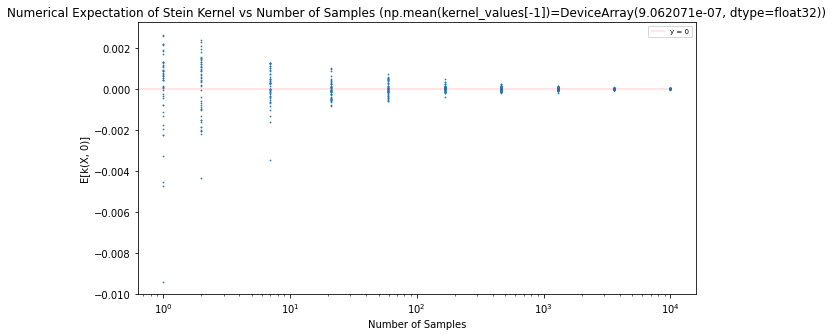

In [8]:
dimensions = 3
c = 10
beta = -0.5
gaussian = Gaussian(mu=np.zeros((dimensions, 1)), covariance=np.eye(dimensions))
inverse_multi_quadratic_kernel = InverseMultiQuadraticKernel(c, beta)
stein_kernel = SteinKernel(distribution=gaussian, kernel=inverse_multi_quadratic_kernel)
n_samples = np.logspace(0, 4, 10).astype(int)
n_trials = 50
kernel_values = []
sample_values = np.repeat(n_samples, n_trials).reshape(-1, n_trials)
for n_sample in n_samples:
    kernel_values.append(
        vmap(
            lambda samples: jnp.mean(
                vmap(
                    lambda x_i: stein_kernel.k(
                        x_i, (0 * np.ones((dimensions,))).astype(np.float64)
                    )
                )(samples)
            )
        )(stein_kernel.distribution.sample((n_trials, n_sample)).astype(np.float64))
    )


fig = plt.figure()
fig.set_figwidth(10)
fig.set_figheight(5)
ax = fig.add_subplot(1, 1, 1)
ax.set_title(
    f"Numerical Expectation of Stein Kernel vs Number of Samples ({np.mean(kernel_values[-1])=})"
)
ax.set_xscale("log")
ax.set_xlabel("Number of Samples")
ax.set_ylabel("E[k(X, 0)]")
ax.plot(
    [0] + list(n_samples),
    np.zeros(len(n_samples) + 1),
    "r",
    label="y = 0",
    linewidth=0.2,
)
plt.scatter(sample_values, np.array(kernel_values), s=0.5)
ax.legend()
plt.show()

# Kernel Stein Discrepancy

Finally, we can define the Kernel Stein Discrepancy (KSD):

$$KSD_k^2[\mathbb{Q}, T, G_k] = \mathbb{E}_{X, \tilde{X} \sim \mathbb{Q}}[k_{\mathbb{P}}(X, \tilde{X})]$$

Moreover, the unbiased estimate:

$$\hat{KSD}_k^2[Q_n, T, G_k] = \frac{1}{n(n-1)} \sum_{i=1}^n \sum_{j\neq i}^n k_{\mathbb{P}}(x_i, x_j)$$

where $x_k \sim \mathbb{Q}$ for $k=1,...,n$


We can observe the KSD's behaviour as we shift the mean or scale the covariance of $\mathbb{Q}$:

In [9]:
inverse_multi_quadratic_kernel = InverseMultiQuadraticKernel(c=10, beta=-0.5)
gaussian = Gaussian(
    mu=np.zeros((2, 1)),
    covariance=np.eye(2),
)
stein_kernel = SteinKernel(
    kernel=inverse_multi_quadratic_kernel,
    distribution=gaussian,
)

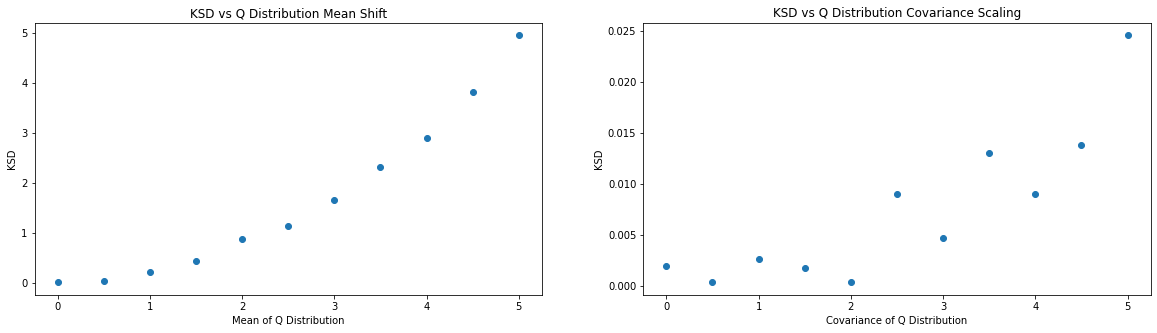

In [10]:
mu_shifts = np.arange(0, 5.5, 0.5)
n_q_samples = 100
ksd_vals = []

ksd = KernelSteinDiscrepancy(stein_kernel=stein_kernel)

for i, mu_shift in enumerate(mu_shifts):
    Y = np.random.multivariate_normal(
        stein_kernel.distribution.mu.flatten() + mu_shift,
        stein_kernel.distribution.covariance,
        n_q_samples,
    )
    ksd_vals.append(ksd.compute(Y))


fig, ax = plt.subplots(1, 2)
fig.set_figwidth(20)
fig.set_figheight(5)
ax[0].scatter(mu_shifts, ksd_vals)
ax[0].set_title("KSD vs Q Distribution Mean Shift")
ax[0].set_xlabel("Mean of Q Distribution")
ax[0].set_ylabel("KSD")

covariance_scales = np.arange(0, 5.5, 0.5)
ksd_vals = []
n_q_samples = 200
for i, covariance_scale in enumerate(covariance_scales):
    Y = np.random.multivariate_normal(
        stein_kernel.distribution.mu.flatten(),
        stein_kernel.distribution.covariance * covariance_scale,
        n_q_samples,
    )
    ksd_vals.append(ksd.compute(Y))
ax[1].scatter(covariance_scales, ksd_vals)
ax[1].set_title("KSD vs Q Distribution Covariance Scaling")
ax[1].set_xlabel("Covariance of Q Distribution")
ax[1].set_ylabel("KSD")
plt.show()

# KSD vs MMD

Here, we explore the link between the KSD and the MMD. We know the MMD is:

$$MMD^2[\mathcal{H}, X, Y] =  \mathbb{E}_{X, \tilde{X} \sim \mathbb{P}}[k(X,\tilde{X})]-2\mathbb{E}_{X \sim \mathbb{P},Y \sim \mathbb{Q}}[k(X,Y)]+\mathbb{E}_{Y, \tilde{Y} \sim \mathbb{Q}}[k(Y,\tilde{Y})]$$

If we choose a Stein Kernel, $k_{\mathbb{P}}$ for the MMD, and utilise the special property:

$$\mathbb{E}_{X \sim \mathbb{P}}[k_{\mathbb{P}}(X, x)] = 0$$

for all $x \in \mathbb{R}^d$.

Then $\mathbb{E}_{X, \tilde{X} \sim \mathbb{P}}[k_{\mathbb{P}}(X,\tilde{X})=0]$ and $\mathbb{E}_{X,Y}[k_{\mathbb{P}}(X,Y)]=0$, leaving us with:

$$MMD^2 =  \mathbb{E}_{Y, \tilde{Y} \sim \mathbb{Q}}[k_{\mathbb{P}}(Y,\tilde{Y})]$$

which is equivalent to the KSD:

$$KSD^2 = \mathbb{E}_{X, \tilde{X} \sim \mathbb{Q}}[k_{\mathbb{P}}(X, \tilde{X})]$$

We can see that the KSD can be derived from the MMD when using a Stein Kernel. However, without the terms involving $X \sim \mathbb{P}$, the KSD only requires samples from $\mathbb{Q}$. We can visualise that by using the same Stein kernel for both the KSD and MMD, increasing the number of samples for $\mathbb{P}$ will result in the MMD approaching the KSD. 

To explore this, we will draw varying number of samples from $\mathbb{P}$ and $\mathbb{Q}$ for $K$ trials, for which we will compute mean KSD and MMD values for comparison.

For notation:

$$X^{m}_i \sim \mathbb{P}$$ 

a set of $m$ samples drawn from $\mathbb{P}$ for the $i$th trial.

$$Y^{n}_j \sim \mathbb{Q}$$ 

a set of $n$ samples drawn from $\mathbb{Q}$ for the $j$th trial.

$$KSD^n_j = ksd(Y^{n}_j)$$

the KSD computed using $Y^{n}_j \sim \mathbb{Q}$.


$$MMD^{m, n}_{i, j} = mmd(X^{m}_i, Y^{n}_j)$$

the MMD computed using $X^{m}_i \sim \mathbb{P}$ and $Y^{n}_j \sim \mathbb{Q}$.




In [11]:
inverse_multi_quadratic_kernel = InverseMultiQuadraticKernel(c=10, beta=-0.5)
gaussian = Gaussian(
    mu=np.zeros((2, 1)),
    covariance=np.eye(2),
)
stein_kernel = SteinKernel(
    kernel=inverse_multi_quadratic_kernel,
    distribution=gaussian,
)

n_trials = 100

number_p_samples = np.ceil(np.logspace(np.log(2) / np.log(10), 2, 5)).astype(int)

p_samples = [stein_kernel.distribution.sample((n_trials, n)) for n in number_p_samples]

max_num_q_samples = 50
number_q_samples = np.linspace(2, max_num_q_samples, 10).astype(int)

q_samples = [stein_kernel.distribution.sample((n_trials, n)) for n in number_q_samples]

ksd_vals = np.zeros((len(number_q_samples), n_trials))
mmd_vals = np.zeros((len(number_q_samples), len(number_p_samples), n_trials, n_trials))

ksd = KernelSteinDiscrepancy(stein_kernel=stein_kernel)
mmd = MaximumMeanDiscrepancy(kernel=stein_kernel)

for i, q_sample in enumerate(q_samples):
    ksd_vals[i, :] = vmap(lambda q_sample_i: ksd.compute(q_sample_i))(q_sample)
    for j, p_sample in enumerate(p_samples):
        mmd_vals[i, j, :, :] = vmap(
            lambda q_sample_i: vmap(
                lambda p_sample_i: mmd.compute(
                    x=p_sample_i,
                    y=q_sample_i,
                )
            )(p_sample)
        )(q_sample)

First, to ensure that the MMD converges to the KSD, we will compute the mean absolute difference:

$$d^{m, n} = \frac{1}{K} \sum_i^N |KSD^n_i - MMD^{m, n}_{i, i}|$$

where the MMD has $m$ samples to approximate $\mathbb{P}$ to calculate the discrepancy with $n$ samples of $\mathbb{Q}$. This is compared to the KSD, which incorporates the closed form of $\mathbb{P}$ to calculate the discrepancy with the same $n$ samples of $\mathbb{Q}$. 

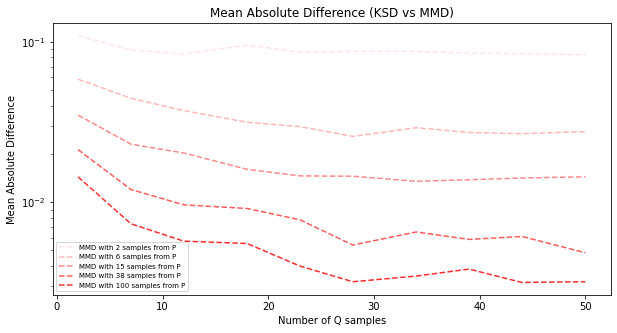

In [12]:
fig, ax = plt.subplots()
fig.set_figwidth(10)
fig.set_figheight(5)
mean_absolute_difference = vmap(
    lambda mmd_vals_i: jnp.mean(jnp.abs(mmd_vals_i - ksd_vals), axis=1), in_axes=1
)(jnp.diagonal(mmd_vals, axis1=2, axis2=3))
for i, number_p_sample in enumerate(number_p_samples):
    shade = 0.9 * (1 - i / len(number_p_samples))
    ax.plot(
        number_q_samples,
        mean_absolute_difference[i, :],
        c=(1, shade, shade),
        label=f"MMD with {number_p_sample} samples from P",
        linestyle="--",
    )
ax.set_yscale("log")
ax.set_title("Mean Absolute Difference (KSD vs MMD)")
ax.set_ylabel("Mean Absolute Difference")
ax.set_xlabel("Number of Q samples")
plt.legend()
plt.show()

As we can see, by increasing both $m$ and $n$, $d^{m, n}$ approaches zero, meaning that each $MMD^{m, n}_{i, i}$ approaches its corresponding $KSD^n_i$.

We can further visualise this by plotting individual trials of samples, showing $MMD^{m, n}_{i, i}$ with its corresponding $KSD^n_i$.

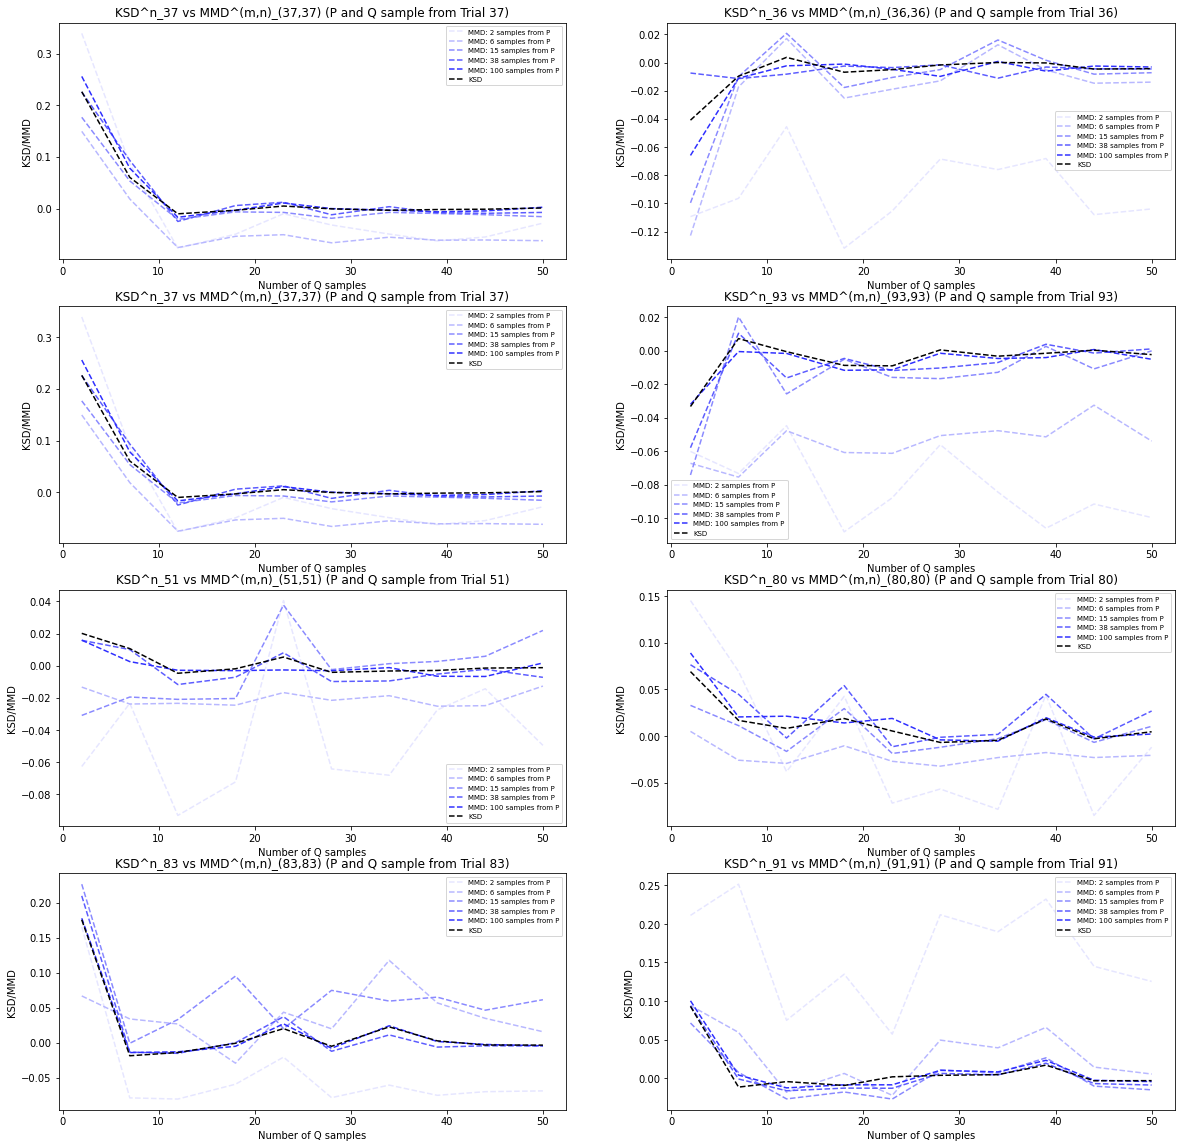

In [13]:
num_x_subplots = 4
num_y_subplots = 2
fig, ax = plt.subplots(num_x_subplots, num_y_subplots)
fig.set_figwidth(20)
fig.set_figheight(20)
for i in range(num_x_subplots):
    for j in range(num_y_subplots):
        trial_index = np.random.randint(n_trials)
        for k, number_p_sample in enumerate(number_p_samples):
            shade = 0.9 * (1 - k / len(number_p_samples))
            ax[i][j].plot(
                number_q_samples,
                jnp.diagonal(mmd_vals, axis1=2, axis2=3)[:, k, trial_index],
                c=(shade, shade, 1),
                label=f"MMD: {number_p_sample} samples from P",
                linestyle="--",
            )

        ax[i][j].plot(
            number_q_samples,
            ksd_vals[:, trial_index],
            c="black",
            label="KSD",
            linestyle="--",
        )
        ax[i][j].set_title(
            f"KSD^n_{trial_index} vs MMD^(m,n)_({trial_index},{trial_index}) (P and Q sample from Trial {trial_index})"
        )
        ax[i][j].set_ylabel("KSD/MMD")
        ax[i][j].set_xlabel("Number of Q samples")
        ax[i][j].legend()
plt.show()

We see that for each pair of $MMD^{m, n}_{i, i}$ and $KSD^n_i$, the MMD plots approach the KSD plot as we increase the number of samples of $\mathbb{P}$. The MMD obtains a better approximation of $\mathbb{P}$ and approaches the closed form solution of the KSD.

Building on this, we can also compare the average KSD,

$$KSD^n = \frac{1}{K}\sum_j^K KSD^n_j$$

with,

$$\frac{1}{K} \sum_i^K MMD^{m, n}_{i, j}$$

averaging the MMD across all sets of samples $X^{m}_i \sim \mathbb{P}$ with a single set of samples $Y^{n}_j \sim \mathbb{Q}$. We can plot and compare the MMD and KSD for selected samples $Y^{n}_j$.

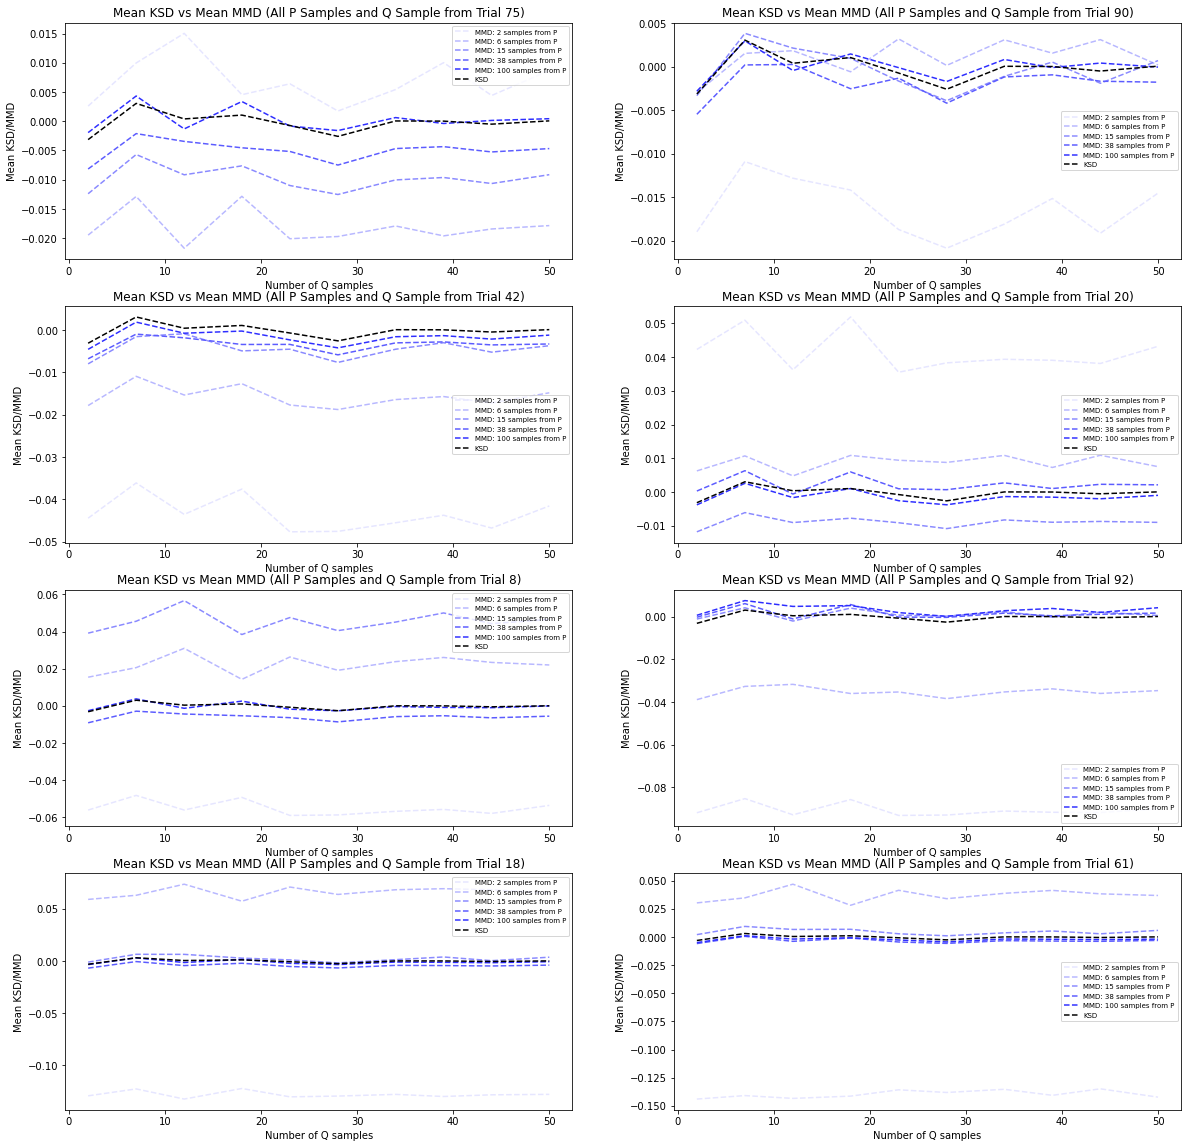

In [14]:
num_x_subplots = 4
num_y_subplots = 2
fig, ax = plt.subplots(num_x_subplots, num_y_subplots)
fig.set_figwidth(20)
fig.set_figheight(20)
for i in range(num_x_subplots):
    for j in range(num_y_subplots):
        q_sample_trial_index = np.random.randint(n_trials)
        for k, number_p_sample in enumerate(number_p_samples):
            shade = 0.9 * (1 - k / len(number_p_samples))
            ax[i][j].plot(
                number_q_samples,
                np.mean(mmd_vals[:, k, :, q_sample_trial_index], axis=-1),
                c=(shade, shade, 1),
                label=f"MMD: {number_p_sample} samples from P",
                linestyle="--",
            )

        ax[i][j].plot(
            number_q_samples,
            np.mean(ksd_vals, axis=1),
            c="black",
            label="KSD",
            linestyle="--",
        )
        ax[i][j].set_title(
            f"Mean KSD vs Mean MMD (All P Samples and Q Sample from Trial {q_sample_trial_index})"
        )
        ax[i][j].set_ylabel("Mean KSD/MMD")
        ax[i][j].set_xlabel("Number of Q samples")
        ax[i][j].legend()
plt.show()

Again, we find that the KSD plots approach the MMD. By averaging MMDs across all sets of samples of $\mathbb{P}$, we are essentially computing the MMD with $nK$ samples from $\mathbb{P}$, improving the approximation of $\mathbb{P}$.


Finally, we plot mean MMD values with mean KSD values. The mean MMD is computed by:

$$MMD^{m, n} = \frac{1}{K}\sum_i^K MMD^{m, n}_{i, i}$$

That is, MMDs are only included where each sample from $\mathbb{P}$ has a unique sample from $\mathbb{Q}$ (i.e. from the same $i$th trial).

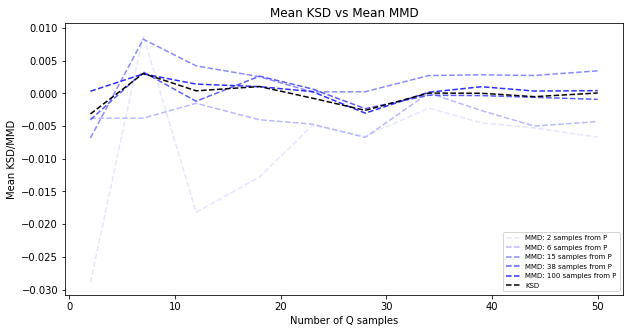

In [15]:
fig, ax = plt.subplots()
fig.set_figwidth(10)
fig.set_figheight(5)

for i, number_p_sample in enumerate(number_p_samples):
    shade = 0.9 * (1 - i / len(number_p_samples))
    ax.plot(
        number_q_samples,
        np.mean(jnp.diagonal(mmd_vals, axis1=2, axis2=3)[:, i, :], axis=-1),
        c=(shade, shade, 1),
        label=f"MMD: {number_p_sample} samples from P",
        linestyle="--",
    )

ax.plot(
    number_q_samples,
    np.mean(ksd_vals, axis=1),
    c="black",
    label="KSD",
    linestyle="--",
)
ax.set_title("Mean KSD vs Mean MMD")
ax.set_ylabel("Mean KSD/MMD")
ax.set_xlabel("Number of Q samples")
plt.legend()
plt.show()

We can see that the MMD plots converge to the KSD plot, which in turn converges to zero as we increase the number of Q samples.